# Systemy uczące się: Modele generatywne i dyskryminatywne

## Zadanie 1
Zadanie polega na implementacji klasyfikatora naiwnego Bayesa dla zmiennych ciągłych gdzie za rozkłady cechy przyjmij rozkłady normalne.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

plt.style.use("ggplot")

Do testowania twojego rozwiązania użyj trzech generatorów danych sztucznych `generate1`, `generate2` oraz `generate3` (funkcje te przyjmują jako argument liczbę elementów do wygenerowania z każdej klasy - domyślnie $N=100$). Sposób ich wywołania jest przedstawiony poniżej:

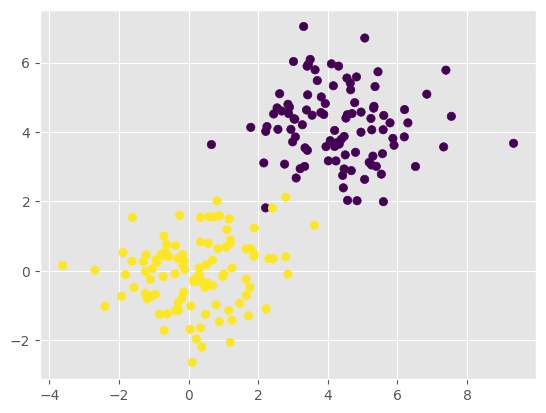

In [5]:
from helpers import generate1, generate2, generate3

X, y = generate1()
plt.scatter(X[:, 0], X[:, 1], c=y)

W implementacji będzie przydatna klasa `norm` z pakietu `scipy`, która zwraca wartości funkcji gęstości prawdopodobieństwa rozkładu normalnego dla zmiennych ciągłych.

In [6]:
from scipy.stats import norm

# (X, mean, std)
norm.pdf(5, 0, 1)  #gęstość prawd. dla 5 z rozkładu standardowego
norm.logpdf(5, 0, 1)  #logarytm gęstości prawd. dla 5 z rozkładu standardowego

-13.418938533204672

Zaimplementuj klasyfikator naiwnego Bayesa dla zmiennych ciągłych. Pamiętaj o zabezpieczniu się przed problemem wynikającym z mnożenia wielu małych liczb (prawdopodobieństw).

In [15]:
class GaussianNaiveBayes(object):
  def __init__(self):
    self.classes = None
    self.means: dict[int, np.ndarray[float]] = {}
    self.stds: dict[int, np.ndarray[float]] = {}
    self.class_log_prob: np.ndarray[float] = None

  def fit(self, X, y):
    self.classes = np.unique(y)
    n_samples = X.shape[0]

    self.class_log_prob = np.zeros(len(self.classes))
    for (i, class_) in enumerate(self.classes):
      classified = X[y == class_]
      self.means[class_] = np.mean(classified, axis=0)
      self.stds[class_] = np.std(classified, axis=0)
      self.class_log_prob[i] = np.log(classified.shape[0] / n_samples)

  def predict_proba(self, X):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    log_prob = np.zeros((n_samples, len(self.classes)))
    for i, c in enumerate(self.classes):
      log_prob[:, i] = self.class_log_prob[i]
      for j in range(n_features):
        log_prob[:, i] += norm.logpdf(X[:, j], self.means[c][j], self.stds[c][j])
    return np.exp(log_prob)

  def predict(self, X):
    return np.argmax(self.predict_proba(X), axis=1)


Przetestuj twój klasyfikator na wygenerowanych wcześniej danych.

In [16]:
gnb = GaussianNaiveBayes()
gnb.fit(X, y)
#Trafność na zbiorze uczącym
np.mean(gnb.predict(X) == y)


0.995

Narysowanie nauczonego klasyfikatora

acc: 0.995


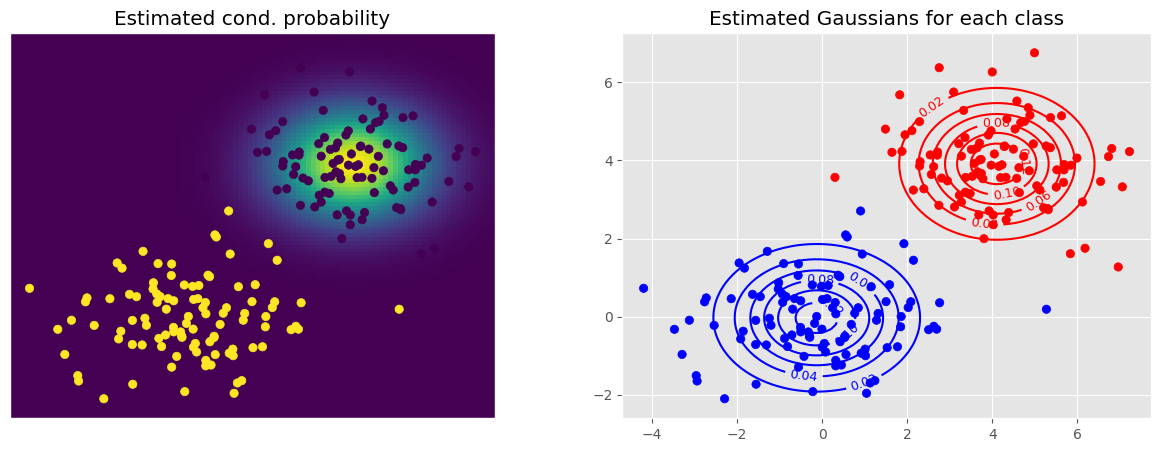

acc: 1.0


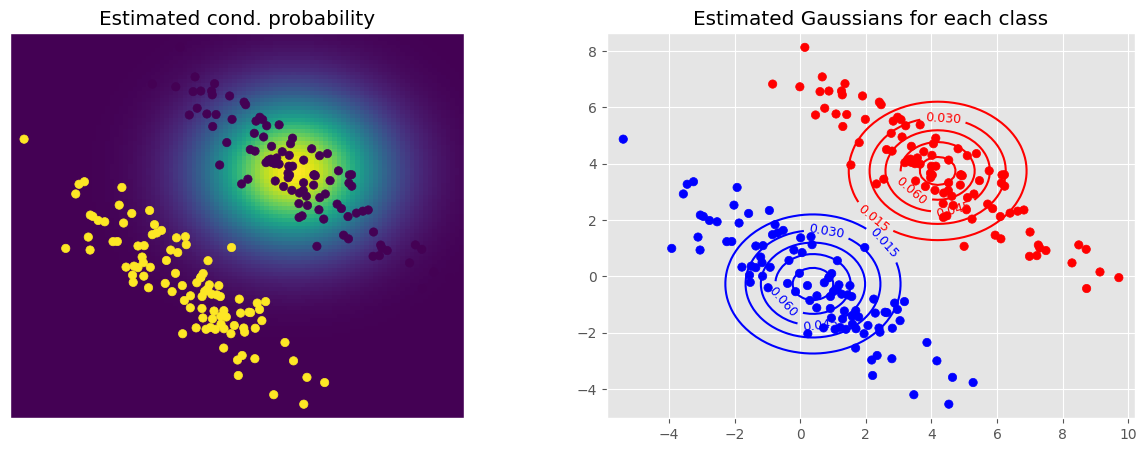

acc: 0.81


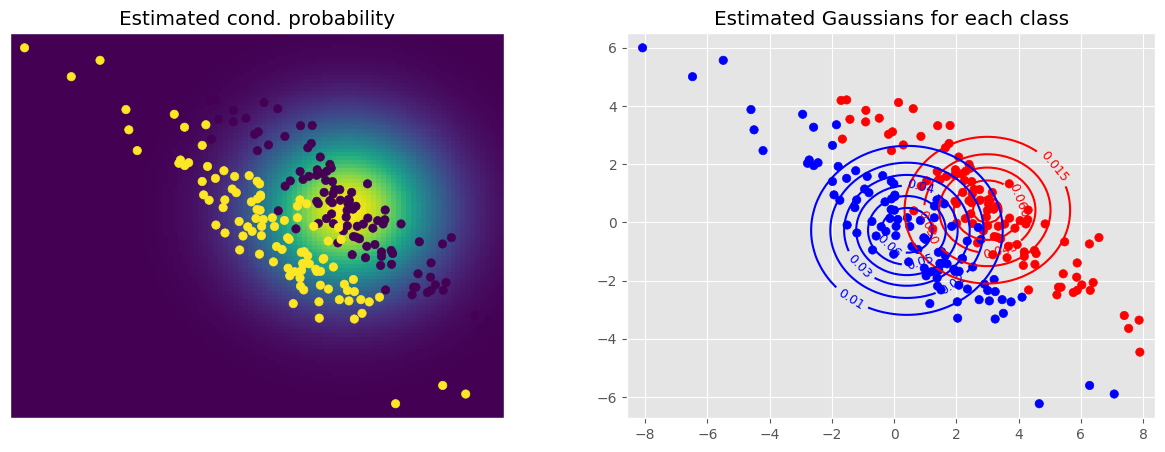

In [17]:
from helpers import plotGaussianBayes
for (X, y) in map(lambda x: x(), [generate1, generate2, generate3]):
  gnb = GaussianNaiveBayes()
  gnb.fit(X, y)
  print(f"acc: {np.mean(gnb.predict(X) == y)}")
  plotGaussianBayes(X, y, gnb)


Użyj funkcji do generowania danych, aby wygenerować zbiór testowy oraz sprawdź na nim trafność klasyfikacji metody.

acc gnb: 1.0
acc gb: 1.0


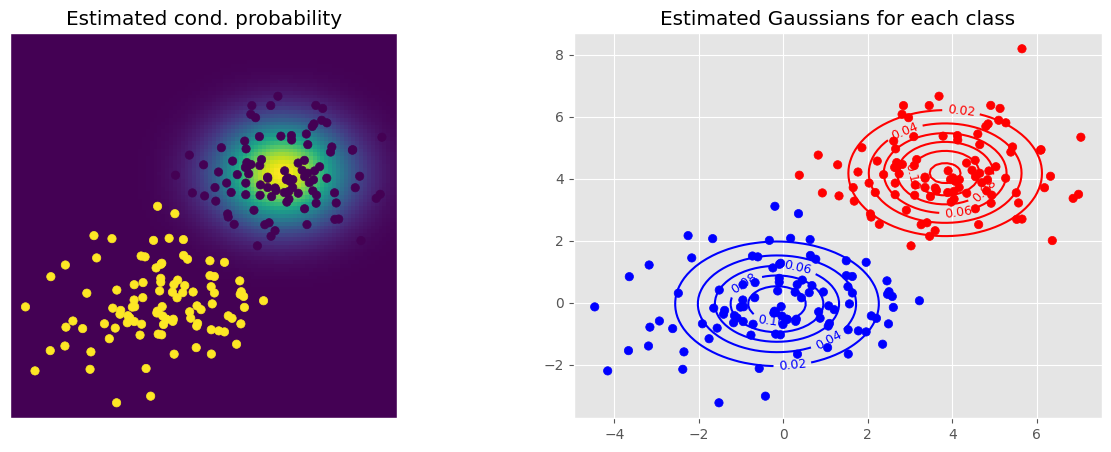

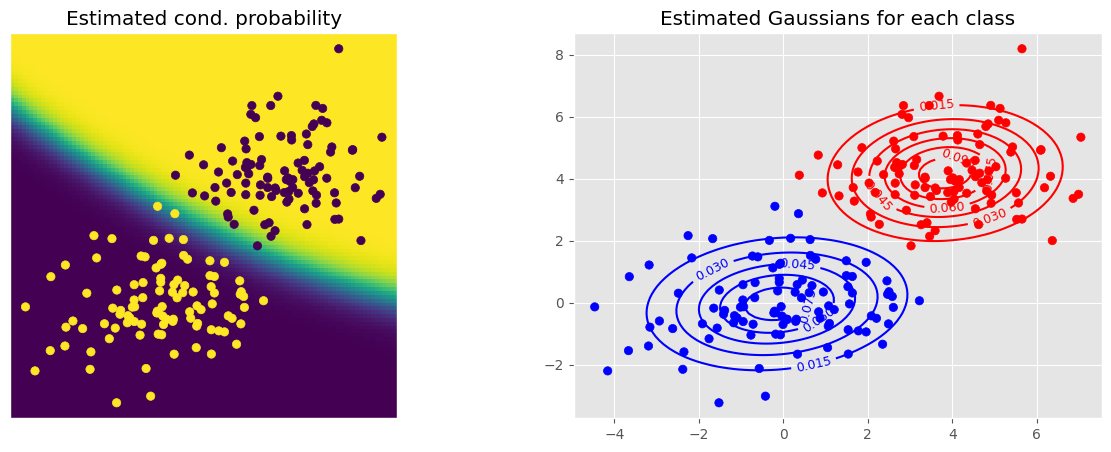

acc gnb: 1.0
acc gb: 1.0


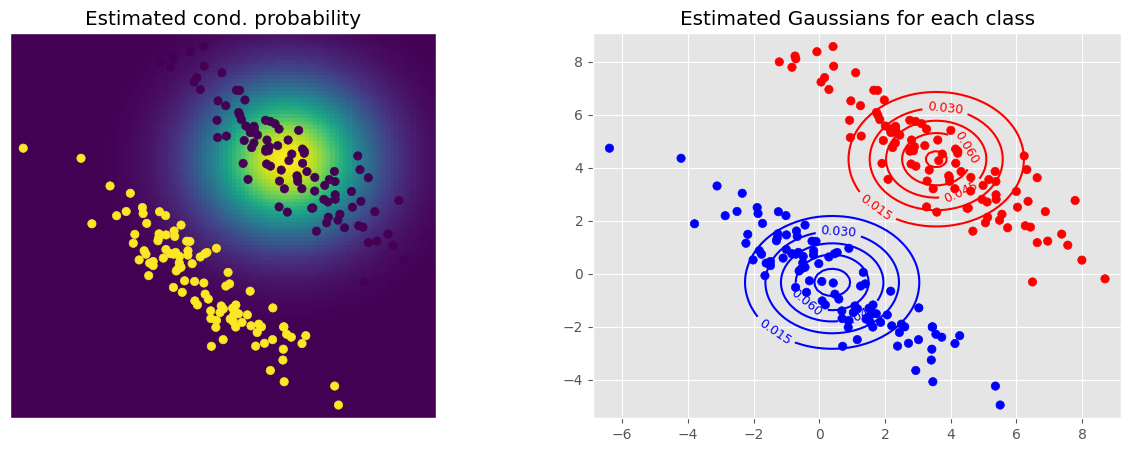

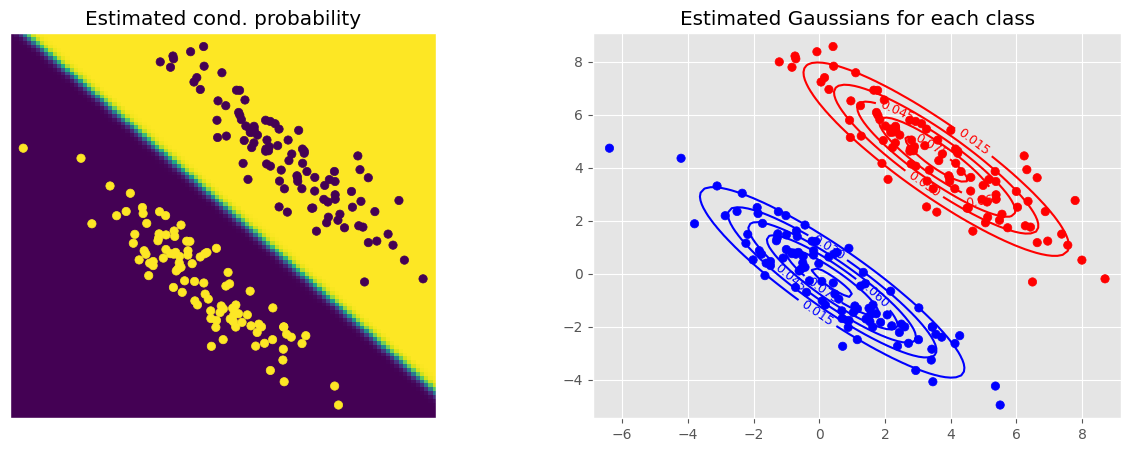

acc gnb: 0.87
acc gb: 0.96


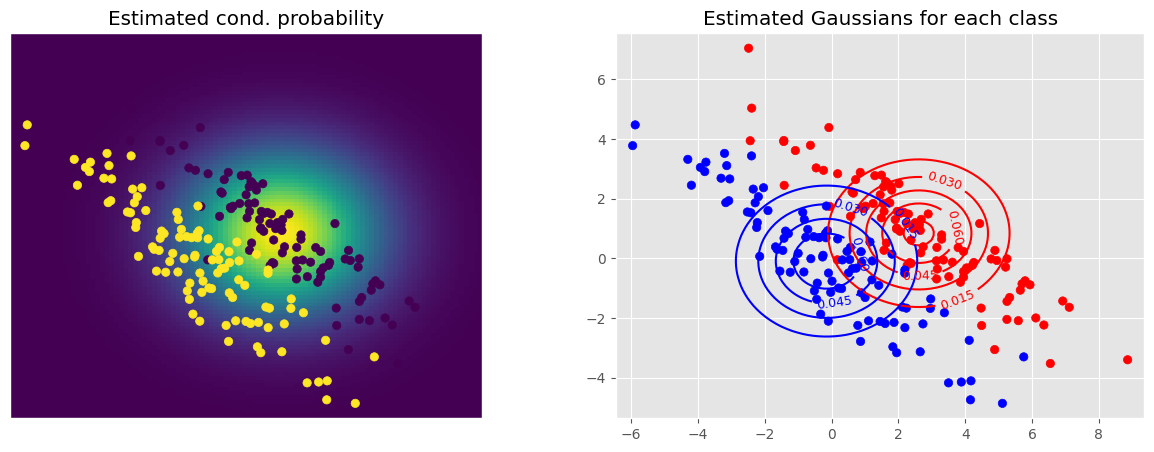

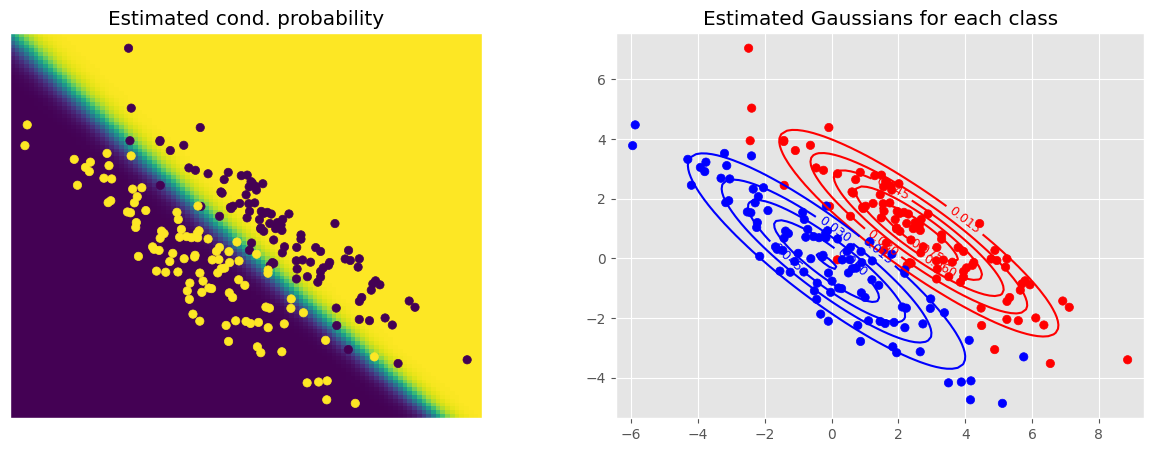

In [11]:
X_test, y_test = generate1(1000)
np.mean(gnb.predict(X_test) == y_test)

from helpers import plotGaussianBayes, GaussianBayes
for (X, y) in map(lambda x: x(), [generate1, generate2, generate3]):
  gnb = GaussianNaiveBayes()
  gb = GaussianBayes()
  gnb.fit(X, y)
  gb.fit(X, y)
  print(f"acc gnb: {np.mean(gnb.predict(X) == y)}")
  print(f"acc gb: {np.mean(gb.predict(X) == y)}")
  plotGaussianBayes(X, y, gnb)
  plotGaussianBayes(X, y, gb)


In [ ]:
# Tu będą testy sprawdzarki

1. Możliwe, że klasyfikator `GaussianBayes` nie jest w stanie uzyskać 100% trafności nawet na zbiorze uczącym, ze względu na to, że uzyskane dane nie zawierają wartości skrajnych rozkładów, pojawiających się z bardzo niskim prawdopodobieństwem, które pozwalałby na dokładnie określenie rozkładu danych. Dodatkowo szacowanie parametrów statystycznych, takich jak średnie i macierze kowariancji, jest obarczone błędem. Ten błąd wpływa na zdolność klasyfikatora do dokładnego przewidywania klas.
2. Tak, gdybyśmy znali prawdziwe wartości średnich i macierz wariancji-kowariancji cech, można by osiągnąć 100% trafności, ponieważ klasyfikator miałby pełną wiedzę o całej strukturze danych. Jednak w realiach taki klasyfikator byłby przeuczony i mógłby gorzej radzić sobie z nowymi, nieznanych wcześniej prawdziwymi danymi. Jest mało prawdopodobne, aby uzyskać klasyfikator bardziej trafny niż taki, który zna prawdziwe parametry rozkładu danych, ale też kluczowe znaczenie ma generalizacja na nowe pojawiające się dane, a nie tylko dopasowanie do danych uczących.

# Zadanie 2
Klasyfikator naiwnego Bayesa często jest używany do klasyfikacji tekstów. Przetestuj działanie algorytmów na podanym rzeczywistym zbiorze danych: 
> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Podany zbiór jest wieloklasowy, więc poniższy kod wybiera z niego podzbiór postów tylko z dwóch tematów.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

vectorizer = TfidfVectorizer(binary=True, use_idf=False, norm=None)  # Przekształcenie tekstu na cechy binarne
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
vectors = vectors.toarray()
vectors_test = vectors_test.toarray()

Dokumenty w zbiorze można wyświetlić w następujący sposób.

In [ ]:
newsgroups_train.data[0:3]

Analogicznie możemy uzyskać dostęp do informacji o klasach.

In [ ]:
newsgroups_train.target[0:3]

i do "zbinaryzowanego" tekstu

In [ ]:
vectors[0:3]

Wytrenuj klasyfikator Naiwnego Bayesa z rozmywaniem estymat (patrz pakiet `sklearn`) i sprawdż jego trafność na zbiorze uczącym i testowym.
UWAGA: wytrenowany klasyfikator powinien być przypisany do zmiennej `nb` na której `nb.predict()` zostaną wykonane testy

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(vectors, newsgroups_train.target)

print(f"acc na zbiorze uczącym: {nb.score(vectors, newsgroups_train.target) * 100:.2f}%")
print(f"acc na zbiorze testowym: {nb.score(vectors_test, newsgroups_test.target) * 100:.2f}%")

In [ ]:
# Tu będą testy

**Ćwiczenia**
 - Dlaczego klasyfikator Naiwnego Bayesa dość dobrze sprawdza się do powyższego zadania i analogicznych?
 - Przeanalizuj wartości estymat prawdopodobieństw. Które cechy/słowa są najlepszymi wskaźnikami dla podanych klas? Jakie słowa bardzo słabo wskazują na którąkolwiek z klas?
 - Czy byłoby możliwe wytrenowanie równie skutecznego klasyfikatora z mniejszą liczbą cech? W jaki sposób można by to uzyskać?
 - Analizowany zbiór jest oryginalnie wieloklasowy z tego powodu możemy go wykorzystać do wielu testów wybierając różne pary klas. Pełna lista tematów: 'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
 - Czy są pary tematów dla których ten klasyfikator działa znacząco gorzej?
 - Jakie są zalety stosowania klasyfikatora Bayesa dla tego problemu (i w ogólności)? Czy do tego problemu sprawdziłyby się reguły lub drzewa decyzyjne? Dlaczego?
 
 Odpowiedzi na kropki 1, 3 i 6 wpisz poniżej - zostaną sprawdzone.

1. Naiwny bayes dosyć dobrze sprawdza się do powyższego zadania i analogicznych, ponieważ zakłada, że cechy są niezależne od siebie. Pozwala to na efektywne uczenie i przewidywanie wyników. Dodatkowo dobrze sprawdza się w tekstach, gdzie wiele cech może być bardzo rzadkich i to dobrze komponuje się z założeniem o niezależności cech.
3. Można by wybrać tylko te cechy, które mają największe prawdopodobieństwo wystąpienia w danej klasie. Wtedy klasyfikator będzie miał mniejszą liczbę cech, ale będzie miał taką samą skuteczność. Pozwala to na zredukowanie cech i w efekcie posiadanie prostszego klasyfikatora.
6. Zaletą klasyfikatora jest brak potrzeby dużej ilości danych do trenowania i sprawdza się, gdy mamy znaną liczbę klas i cech. Dodatkowo jest szybki i efektywne do uczenia i predykcji. Potrafi rozwiązywać problem wieloklasowy i jest łatwy do interpretacji. Zdaje się też bardziej oporny na przeuczenie. Drzewo decyzyjne dobrze sprawdzi się, gdyby cechy były zależne od siebie. Jednak przy wysokim wymiarze takim jak teksty istnieje rosnąca szansa na przeuczenie, przy dużych drzewach. Dodatkowo drzewa są wolne.